In [19]:
# Setup 

from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

In [20]:
## Least Squares

# load data

import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

In [21]:
# def least square function

from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)
    
    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx
    
    return inter, slope

# least squares for birth weight as function of mother's age

inter, slope = LeastSquares(ages, weights)
inter, slope

    

(6.8303969733110526, 0.017453851471802753)

In [22]:
# intercept better at mean of indep. variable

interMean = inter + slope * 25
print(interMean)

# and slope easier if pounds per decade
slope * 10

7.2667432601061215


0.17453851471802753

In [23]:
# fitted line at given xs

def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

# example

fit_xs, fit_ys = FitLine(ages, inter, slope)


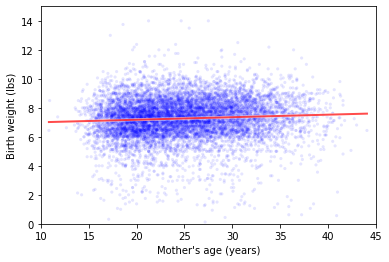

In [35]:
thinkplot.Scatter(ages, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Birth weight (lbs)',
                 axis=[10, 45, 0, 15],
                 legend=False)

## Residuals 

In [36]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [37]:
live['residual'] = Residuals(ages, weights, inter, slope)

In [40]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333312,
 17.74035928143719,
 20.506304824561838,
 23.455752212389893,
 26.435156146179903,
 29.411177432543294,
 32.30232530120497,
 35.240273631840736,
 38.10876470588231,
 40.91205882352941]

In [41]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

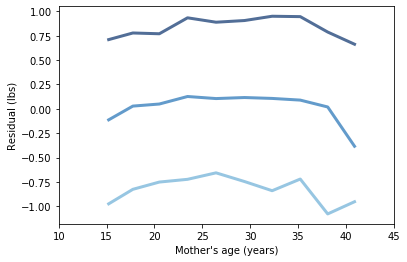

In [42]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)
        
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Sampling Distribution

In [25]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

In [28]:
# resample the live df and return a list of estimates for 'inter' and 'slope'

def SamplingDistribution(live, iters=101):
    t=[]
    for _ in range(iters):
        samples = ResampleRows(live)
        ages = samples.agepreg
        weights = samples.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)
        
    inters, slopes = zip(*t)
    return inters, slopes



In [29]:
inters, slopes = SamplingDistribution(live, iters=1001)

In [30]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print("mean, SE, CI", mean, stderr, ci)

In [31]:
Summarize(inters)

mean, SE, CI 6.829100003322485 0.07039643855988703 (6.713625394006535, 6.944760835257555)


In [33]:
# Exercise 

iters = 1000
estimates1 = ResampleRows(live)
estimates2 = [estimates1.totalwgt_lb.mean() for _ in range(iters)]

Summarize(estimates2)

mean, SE, CI 7.252247455189202 8.881784197001252e-16 (7.2522474551892016, 7.2522474551892016)


## Visualizating uncertainty 


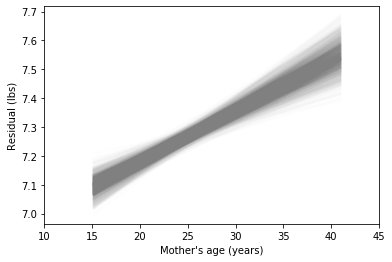

In [43]:

for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='grey', alpha=0.01)
    
thinkplot.Config(xlabel = "Mother's age (years)",
                ylabel = 'Residual (lbs)',
                xlim = [10,45])


In [44]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

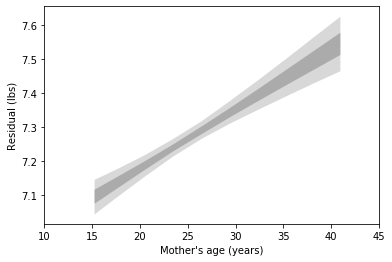

In [45]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])